In [60]:

import importlib
import modules
from collections import Counter
import numpy as np
import powerlaw
importlib.reload(modules)

from modules import CA
from modules import triangulize_evolution
from modules import find_jams
import matplotlib.pyplot as plt

from modules import run_model_stochastic
import random


importlib.reload(modules)


<module 'modules' from '/Users/carokluin/Documents/CSM/ComplexSystems/Project_complexsystems/CSS-Group1/modules.py'>

# Traffic density heatmap
## We could plot the traffic density over time, see if it approaches the critical density like we would expect for Self-Organized Criticality

In [45]:
def plot_traffic_density(evolution):
    """
    Plot the traffic density heatmap for a given density evolution.

    Parameters:
    - evolution (numpy.ndarray): Traffic density evolution over time and space.
    """
    plt.figure(figsize=(10, 6))
    plt.imshow(evolution, cmap='YlOrRd', aspect='auto', origin='lower')
    plt.colorbar(label='Traffic Density')
    plt.xlabel('Position')
    plt.ylabel('Time Step')
    plt.title('Traffic Density Evolution')

    plt.show()


# Density as function of critical exponent 

In [46]:
#Fit power law curve: density as a function of the critical exponents
# Calculate mean and standard deviation of critical exponents
mean_critical_exponents = np.mean(all_critical_exponents, axis=0)
std_critical_exponents = np.std(all_critical_exponents, axis=0)

# Fit a curve to the mean critical exponents
def func(x, a, b):
    return a * x ** -b 

popt, pcov = curve_fit(func, all_densities[0], mean_critical_exponents, p0=[1, 0.5])

# Plot the results
plt.figure(figsize=(8, 6))

#Plot individual datapoints from iterations
for i in range(n_alpha):
    plt.plot(all_densities[i], all_critical_exponents[i], 'o', color="blue")

#Plot the mean values with std dev
plt.errorbar(all_densities[0], mean_critical_exponents, yerr=std_critical_exponents, fmt='o-', color='black', label='Mean ± StdDev')

#plot the fitted curve
x_fit = np.linspace(min(all_densities[0]), max(all_densities[0]), 100)
y_fit = func(x_fit, *popt)
plt.plot(x_fit, y_fit, '--', color='red', label=f'Fitted Curve: a={popt[0]:.2f}, b={popt[1]:.2f}')

plt.xlabel('Density (p)')
plt.ylabel('Fitted Critical Exponent')
plt.title('Critical Exponent vs. Density for L=500')
plt.legend()
plt.show()

NameError: name 'all_critical_exponents' is not defined

# Functions that checks if powerlaw distribution can be fitted

In [ ]:
#set up function to fit power law distribution
def analyze_powerlaw_distribution(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    (Only designed for heavy tailed distributions!)
    Makes use of the Kolmogorov-Smirnov test for which H0: data is power-law distributed, HA: data is not power-law distributed
    If H0 is rejected, the function will check if the data is exponentially distributed 
    If the function is not exponentially distributed, the function will return:
      "Not a power-law distribution (No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    ks_stat, ks_p_value = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

    # Analyze the fit and return the result
    if ks_p_value < 0.05:
        # Reject the null hypothesis (data is unlikely to be power-law distributed)
        result = "Not a power-law distribution"

        # Check for alternative distribution (exponential)
        if fit.power_law.alpha is not None:
            result += f" (Exponential fit p-value: {ks_p_value:.4f})"
        else:
            result += " (No alternative distribution fit available)"
    else:
        # Accept the null hypothesis (data is likely to be power-law distributed)
        result = "Power-law distribution"

    return result



# Example of how to use the function analyze_powerlaw_distribution

Calculating best minimal value for power law fit
Power-law distribution


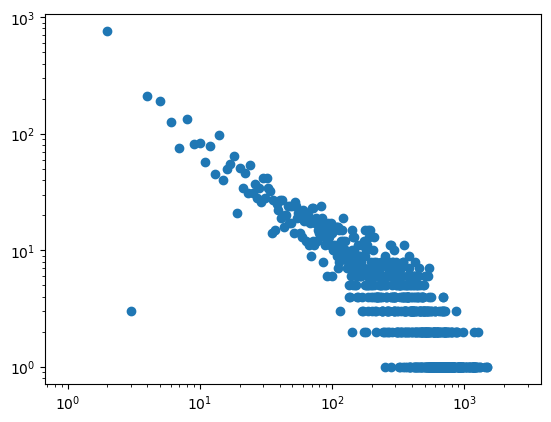

In [ ]:

lifespan_count, jam_count = run_model_stochastic(p, L, T, n_repetitions, v_max, p_slowdown)

result_jam_test = analyze_powerlaw_distribution(list(jam_count.elements()))
print(result_jam_test)

#plt.hist(list(jam_size_counter.elements()), bins=100, density=True, label="Jam size distribution")
plt.loglog(range(1, int(max(jam_count.keys()))), [jam_count[i] for i in range(1, int(max(jam_count.keys())))], 'o')

# Function that not only checks powerlaw 2.0 
## Function that checks powerlaw versus exponential AND checks for bionomial, poisson and gamma 

In [ ]:
#set up function to fit power law distribution and other distributions
def analyze_powerlaw_distribution2(data):
    """
    Function that analysis the distribution of given data with the powerlaw package
    
    Makes use of the Kolmogorov-Smirnov test for which H0: data is .. distributed, HA: data is not .. distributed
    If H0 is rejected for the power law distribution, the function will check if the data is exponentially,bionomial,gamma or poisson distributed 
    If the function is not matched with any of these distributions, the function will return:
      "No alternative distribution fit available"


    Input: data (array-like)
    Output: string with distribution type

    """
    #Make data in array format
    data = np.asarray(data)

    #Fit to a power-law distribution
    fit = powerlaw.Fit(data, discrete=True, verbose=True)

    #Goodness of fit using the Kolmogorov-Smirnov test for power-law vs. exponential
    ks_stat_powerlaw, ks_p_value_powerlaw = fit.distribution_compare('power_law', 'exponential', normalized_ratio=True)

#Check for power law distribution
    if ks_p_value_powerlaw < 0.05:
        result = "Not a power-law distribution"

        #Calculate p-values for alternative distributions
        ks_p_value_exponential = ks_2samp(data, np.random.exponential(np.mean(data), len(data)))[1]
        ks_p_value_poisson = ks_2samp(data, poisson.rvs(np.mean(data), size=len(data)))[1]
        ks_p_value_binomial = ks_2samp(data, np.random.binomial(n=int(np.mean(data)), p=0.5, size=len(data)))[1]
        ks_p_value_gamma = ks_2samp(data, gamma.rvs(np.mean(data)/2, scale=2, size=len(data)))[1]

        #Check alternative distributions, because we did 4 tests, we need to correct for multiple testing with bonferroni (0.05/4)
        if ks_p_value_exponential < 0.05/4:
            result += f" (Exponential fit p-value: {ks_p_value_exponential:.4f})"
        elif ks_p_value_poisson < 0.05/4:
            result += " (Poisson distribution)"
        elif ks_p_value_binomial < 0.05/4:
            result += " (Binomial distribution)"
        elif ks_p_value_gamma < 0.05/4:
            result += " (Gamma distribution)"
        else:
            result += " (No alternative distribution fit available)"

    else:
        result = "Power-law distribution"


# Include enter and exit in NaSch model 
## Simulating influx and outflux to see critical behavior



In [ ]:

#initialize NaSch model with entry point
def initial_state_nasch_with_entry(L, p, v_max):
    """
    Function to generate an initial state for the NaSch model with entry point.
    It returns the initial state of the CA.

    Parameters:
    - L (int): The length of the CA.
    - p (float): The probability of a cell being 1 in the initial state.
    - v_max (int): Maximum speed of vehicles.

    Returns:
    - initial_state (list): The initial state of the CA. It contains a tuple for every cell,
                            with the first element indicating whether the cell is occupied
                            and the second element indicating the speed of the vehicle.
    """
    initial_state = [(False, 0) if random.random() > p else (True, random.randint(1, v_max)) for _ in range(L)]

    return initial_state



Modify Entry and Exit based on Density? Is that correct 

In [67]:
#nasch_step_with_entry_exit function, ONLY enter at begin and exit at end!!!
def nasch_step_with_entry_exit(current_state, v_max, p_slowdown, p_entry, p_exit):
    """
    Function to perform a single timestep of the NaSch model with entry and exit points.

    Parameters:
    - current_state (list): The current state of the CA. It contains a tuple for every cell,
                            with the first element indicating whether the cell is occupied
                            and the second element indicating the speed of the vehicle.
    - v_max (int): Maximum speed of vehicles.
    - p_slowdown (float): Probability of slowing down.
    - p_entry (float): Probability of a car entering the system at the entry point.
    - p_exit (float): Probability of a car leaving the system at the exit point.

    Returns:
    - next_state (list): The next state of the CA. Same format as current_state.
    """
    # Initialize the next state with the current state
    next_state = current_state.copy()

    # Entry: Check if a new car should enter at the entry point (only if the first cell is empty)
    if random.random() < p_entry:
        next_state[0] = (True, random.randint(1, v_max))

    # Acceleration: Increase the speed of each vehicle by 1, up to the maximum speed
    next_state = [(x[0], min(x[1] + 1, v_max)) for x in next_state]

    # Slowing down: Slow down with probability p_slowdown
    next_state = [(x[0], max(x[1] - 1, 0) if random.random() < p_slowdown else x[1]) for x in next_state]

    # Movement: Move each vehicle forward by its speed (only if the next cell is empty)
    for i in range(len(next_state) - 1, 0, -1): #loop over lattice cells in reverse order
        if next_state[i - 1][0] and not next_state[i][0] and random.random() < p_exit: # Check if the next cell is empty and previous cell occupied.
            next_state[i] = (False, 0)  #If the conditions are met,  the current cell (i) is updated to be empty (False) with a speed of 0.

    # Update the state after movement
    for i in range(len(next_state) - 1, 0, -1):
        next_state[i] = next_state[i - 1]

    # Clear the first cell after moving others
    next_state[0] = (False, 0)

    return next_state

In [ ]:

initial_state = initial_state_nasch_with_entry(L, initial_density, v_max)
evolution = [initial_state]

nasch_step_with_entry_exit(evolution[-1], v_max, p_slowdown, p_entry, p_exit)

In [62]:
def run_model_stochastic_with_entry_exit(p, L, T, n_repetitions=100, v_max=5, p_slowdown=0.1, p_entry=0.1, p_exit=0.05,
                                         triangular=False, visualize=False, return_evolutions=True):
    """
    Function to run the NaSch model for a given p, L, T with entry and exit points.

    Parameters:
    - p (float): The probability of a cell being 1 in the initial state.
    - L (int): The length of the simulation.
    - T (int): The number of timesteps.
    - n_repetitions (int): The number of times the model should be run.
    - v_max (int): Maximum speed of vehicles.
    - p_slowdown (float): Probability of slowing down.
    - p_entry (float): Probability of a car entering the system at the entry point.
    - p_exit (float): Probability of a car leaving the system at the exit point.

    Returns:
    - lifespan_counter (Counter): A counter with the lifespans of all the jams found in the evolutions of the model.
    - jam_counter (Counter): A counter with the sizes of all the jams found in the evolutions of the model.
    - all_evolutions (list): A list containing the evolution of the model for every repetition.
                             Only returned if return_evolutions is True.
    """
    total_lifespans = []
    total_jam_sizes = []

    all_evolutions = []

    for i in range(n_repetitions):
        # Create initial state
        initial_state = initial_state_nasch_with_entry(L, p, v_max)

        # Run the model
        evolution = [initial_state]
        for t in range(T):
            current, next = nasch_step_with_entry_exit(evolution[-1], v_max, p_slowdown, p_entry, p_exit)
            evolution[-1] = current
            evolution.append(next)
        
        all_evolutions.append(evolution)

        location_states = np.array([[cell[0] for cell in state] for state in evolution])

        if triangular:
            location_states = triangulize_evolution(location_states)

        jams, lifespans = find_jams(location_states, add_lifespans=True)
        
        jam_sizes = [jam[1] for jam in jams]
        total_jam_sizes += jam_sizes
        total_lifespans += lifespans

    lifespan_counter = Counter(total_lifespans)
    jam_counter = Counter(total_jam_sizes)

    if return_evolutions:
        return lifespan_counter, jam_counter, all_evolutions

    return lifespan_counter, jam_counter

In [63]:
def calculate_flow_nasch(evolution):
    """
    Function to calculate the total flow of the NaSch model. The flow is defined as the 
    amount of car movement in total. This is calculated by summing the total movement of cars.
    """
    total_flow = 0
    
    # Check all timesteps but the last one, because we assume that no movement happens in the last timestep
    for t in range(len(evolution[:-1])):
        for i in range(len(evolution[t])):
            speed = evolution[t][i][1]
            car_present = evolution[t][i][0]
            if car_present:
                # assert that there's a car in the cell i + speed in the next timestep
                # Check if i + speed is within the bounds of the road length
                if i + speed < len(evolution[t]) and i + speed >= 0:
                    assert evolution[t + 1][i + speed][0], f"There should be a car in the next timestep (error at t = {t}, i = {i}, speed = {speed}). Evolution at t={t}: {evolution[t]}, Evolution at t+1={t+1}: {evolution[t+1]}"

                
                total_flow += speed
    
    return total_flow

In [ ]:

def plot_model_evolution(evolution, v_max, title="NaSch Model Evolution", cmap="Greys"):
    """
    Function to plot the evolution of the NaSch model.

    Parameters:
    - evolution (list): List containing the evolution of the model for each timestep.
    - v_max (int): Maximum speed of vehicles.
    - title (str): Title of the plot.
    - cmap (str): Colormap for the heatmap.

    Returns:
    - None (displays the plot).
    """
    density_evolution = np.array([[np.sum([cell[0] for cell in state]) / len(state) for state in evolution]])

    plt.figure(figsize=(10, 6))
    plt.imshow(density_evolution, cmap=cmap, origin="lower", aspect="auto", extent=[0, len(evolution[0]), 0, len(evolution)])
    plt.title(title)
    plt.xlabel("Time Step")
    plt.ylabel("Cell Index")
    plt.colorbar(label="Density")
    plt.yticks(np.arange(0, len(evolution) + 1, 5))
    plt.xticks(np.arange(0, len(evolution[0]) + 1, 5))
    plt.show()



In [66]:
# Vary initial density from 0.1 to 0.9
density_values = [0.1, 0.3, 0.5, 0.7, 0.9]
flow_values = []
L=300
T=int(L / 2)
v_max=5
p_entry=0.1
p_exit=0.05

for initial_density in density_values:
    total_flow = 0

    # Run the model for each initial density
    for _ in range(100):  # Run the model multiple times for each density
        initial_state = initial_state_nasch_with_entry(L, initial_density, v_max)
        evolution = [initial_state]

        for _ in range(T):
            evolution.append(nasch_step_with_entry_exit(evolution[-1], v_max=3, p_slowdown=0.8, p_entry, p_exit))

        total_flow += calculate_flow_nasch(evolution)

    # Average the flow over multiple runs
    average_flow = total_flow / 100
    flow_values.append(average_flow)

# Plot the results
plt.plot(density_values, flow_values, marker='o', linestyle='-')
plt.title('Flow vs Initial Density')
plt.xlabel('Initial Density')
plt.ylabel('Flow')
plt.show()

SyntaxError: positional argument follows keyword argument (480927599.py, line 18)

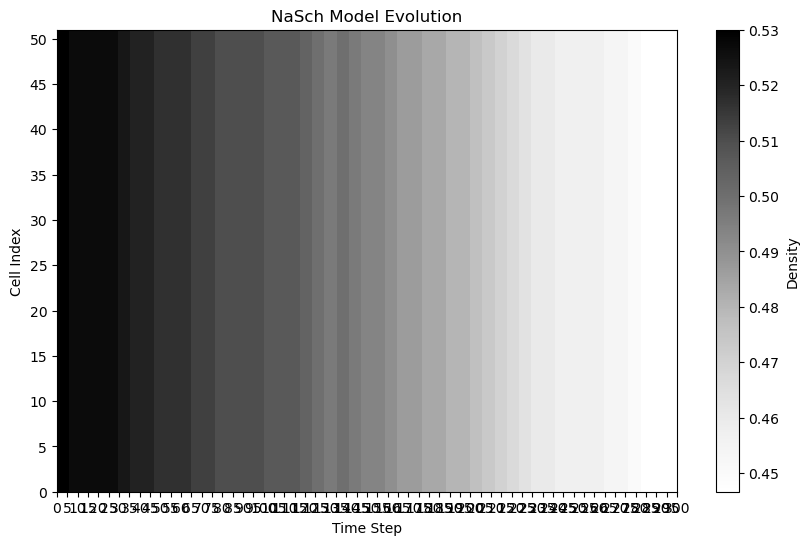

In [ ]:
#try out function with entry and exit
initial_state = initial_state_nasch_with_entry(L=300, p=0.5, v_max=3)
evolution = [initial_state]

for t in range(50):
    next_state = nasch_step_with_entry_exit(evolution[-1], v_max=3, p_slowdown=0.8, p_entry=0.2, p_exit=0.1)
    evolution.append(next_state)

plot_model_evolution(evolution, v_max=5)

In [68]:

#nasch_step_with_entry_exit function, random entry and exit!!!
def nasch_step_with_entry_exit_rand(current_state, v_max, p_slowdown, p_entry, p_exit, p_late_entry, p_early_exit):
    """
    Function to perform a single timestep of the NaSch model with entry and exit points.

    Parameters:
    - current_state (list): The current state of the CA. It contains a tuple for every cell,
                            with the first element indicating whether the cell is occupied
                            and the second element indicating the speed of the vehicle.
    - v_max (int): Maximum speed of vehicles.
    - p_slowdown (float): Probability of slowing down.
    - p_entry (float): Probability of a car entering the system at the entry point.
    - p_exit (float): Probability of a car leaving the system at the exit point.

    Returns:
    - next_state (list): The next state of the CA. Same format as current_state.
    """
    # Initialize the next state with the current state
    next_state = current_state.copy()

    # Entry: Check if a new car should enter (either at the entry point or later)
    for i in range(len(next_state)):
        #Check if current cell is empty
        entry_probability = p_entry if not next_state[i][0] else p_late_entry
    
        # Check if a new car should enter the current cell based on the entry probability
        if random.random() < entry_probability:
                    # If the random number is less than the entry probability, a new car enters
                    # Set the current cell to indicate the presence of a car with a random speed
            next_state[i] = (True, random.randint(1, v_max))

    # Acceleration: Increase the speed of each vehicle by 1, up to the maximum speed
    next_state = [(x[0], min(x[1] + 1, v_max)) for x in next_state]

    # Slowing down: Slow down with probability p_slowdown
    next_state = [(x[0], max(x[1] - 1, 0) if random.random() < p_slowdown else x[1]) for x in next_state]    

    # Movement: Move each vehicle forward by its speed
    for i in range(len(next_state) - 1, 0, -1):
        exit_probability = p_exit if not next_state[i][0] and next_state[i - 1][0] else p_early_exit
        if random.random() < exit_probability:
            next_state[i] = (False, 0)

    # Update the state after movement
    for i in range(len(next_state) - 1, 0, -1):
        next_state[i] = next_state[i - 1]

    # Clear the first cell after moving others
    next_state[0] = (False, 0)

    return next_state

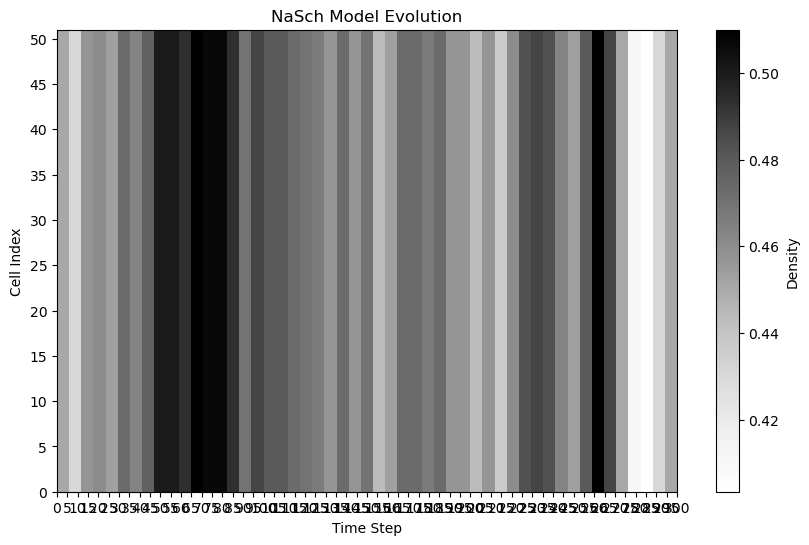

In [70]:
#try out function with entry and exit
initial_state = initial_state_nasch_with_entry(L=300, p=0.5, v_max=3)
evolution = [initial_state]

for t in range(50):
    next_state = nasch_step_with_entry_exit_rand(evolution[-1], v_max=3, p_slowdown=0.8, p_entry=0.1, p_exit=0.1, p_late_entry=0.1, p_early_exit=0.1)
    evolution.append(next_state)

plot_model_evolution(evolution, v_max=5)

In [58]:
def calculate_flow_nasch(evolution):
    """
    Function to calculate the total flow of the NaSch model. The flow is defined as the 
    amount of car movement in total. This is calculated by summing the total movement of cars.
    """
    total_flow = 0
    
    # Check all timesteps but the last one, because we assume that no movement happens in the last timestep
    for t in range(len(evolution[:-1])):
        for i in range(len(evolution[t])):
            speed = evolution[t][i][1]
            car_present = evolution[t][i][0]
            if car_present:
                # assert that there's a car in the cell i + speed in the next timestep
                # Check if i + speed is within the bounds of the road length
                if i + speed < len(evolution[t]) and i + speed >= 0:
                    assert evolution[t + 1][i + speed][0], f"There should be a car in the next timestep (error at t = {t}, i = {i}, speed = {speed}). Evolution at t={t}: {evolution[t]}, Evolution at t+1={t+1}: {evolution[t+1]}"

                
                total_flow += speed
    
    return total_flow

In [71]:
# Parameters
L = 10  # Shorter road length for testing
T = 5   # Fewer time steps for testing
v_max = 3  # Maximum speed of vehicles
p_slowdown = 0.8  # Probability of slowing down
p_entry = 0.1  # Probability of a car entering at the entry point
p_exit = 0.1  # Probability of a car leaving at the exit point
p_late_entry = 0.1  # Probability of a car entering later in the lattice
p_early_exit = 0.1  # Probability of a car leaving earlier in the lattice

# Initial density for testing
initial_density = 0.3

# Run the model for testing
initial_state = initial_state_nasch_with_entry(L, initial_density, v_max)
evolution = [initial_state]

for t in range(T):
    evolution.append(nasch_step_with_entry_exit_rand(evolution[-1], v_max, p_slowdown, p_entry, p_exit, p_late_entry, p_early_exit))
    print(f"Evolution at t={t}: {evolution}")

# Calculate and print the flow
total_flow = calculate_flow_nasch(evolution)
print(f"Total Flow: {total_flow}")


Evolution at t=0: [[(False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (True, 1), (False, 0), (False, 0), (False, 0)], [(False, 0), (True, 2), (False, 1), (False, 1), (False, 0), (False, 0), (False, 0), (True, 1), (False, 0), (False, 0)]]
Evolution at t=1: [[(False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (True, 1), (False, 0), (False, 0), (False, 0)], [(False, 0), (True, 2), (False, 1), (False, 1), (False, 0), (False, 0), (False, 0), (True, 1), (False, 0), (False, 0)], [(False, 0), (False, 1), (True, 2), (False, 0), (False, 1), (False, 0), (True, 1), (True, 1), (False, 0), (False, 0)]]
Evolution at t=2: [[(False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (False, 0), (True, 1), (False, 0), (False, 0), (False, 0)], [(False, 0), (True, 2), (False, 1), (False, 1), (False, 0), (False, 0), (False, 0), (True, 1), (False, 0), (False, 0)], [(False, 0), (False, 1), (True, 2), (False, 0), (False, 1), (False, 0), (True, 1), (True, 1), (False,

AssertionError: There should be a car in the next timestep (error at t = 1, i = 1, speed = 2). Evolution at t=1: [(False, 0), (True, 2), (False, 1), (False, 1), (False, 0), (False, 0), (False, 0), (True, 1), (False, 0), (False, 0)], Evolution at t+1=2: [(False, 0), (False, 1), (True, 2), (False, 0), (False, 1), (False, 0), (True, 1), (True, 1), (False, 0), (False, 0)]

In [77]:
def density_evolution_nasch (evolution):
    """
    Function to calculate the density evolution of the NaSch model. The density is defined as the
    amount of cars in total. This is calculated by summing the total amount of cars.
    Input: 
    - evolution (list): List containing the evolution of the model for each timestep.
    Output:
    - density_evolution (list): List containing the density evolution of the model for each timestep.
    """
    location_evolution = [[x[0] for x in line] for line in evolution]
    density_evolution = [np.sum(line) / len(line) for line in location_evolution]
    return density_evolution



In [91]:
import importlib
from modules import nasch_step
from modules import initial_state_nasch
from modules import run_model_stochastic
importlib.reload(modules)

import cellpylib as cpl

L=100
T=int(L / 2)
p=0.5

current_state = initial_state_nasch(L=10, p=0.5, v_max=3)
evolution = nasch_step(current_state, v_max=3, p_slowdown=0.8)
lifespan_counter, jam_counter, all_evolutions = run_model_stochastic(p, L, T, n_repetitions=100, v_max=3, p_slowdown=0.8, triangular=False, visualize=False, return_evolutions=True)


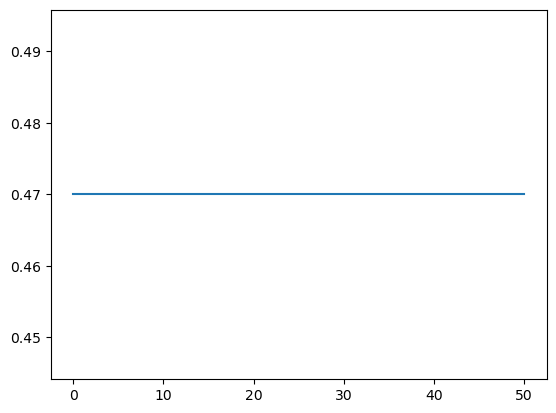

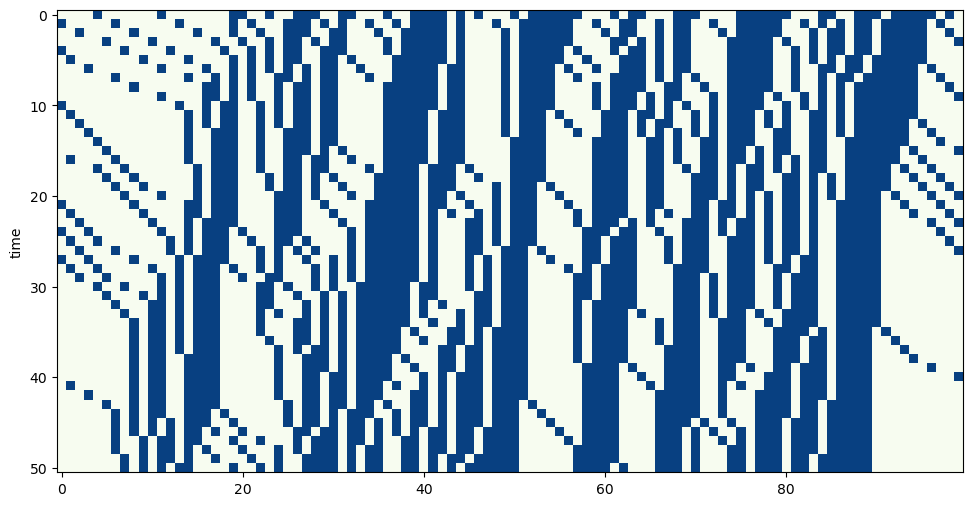

In [92]:
density_test = density_evolution_nasch(all_evolutions[0])
plt.plot(density_test)

location_evolution = [[x[0] for x in line] for line in all_evolutions[0]]

# plot the car evolution
fig, ax = plt.subplots(figsize=(12, 6))  # Adjust the size as needed
cpl.plot(location_evolution, colormap='GnBu')
